<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> ▼ Import Libraries </span>

In [86]:
import os
import sys
import pandas as pd
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import python_utils.common_utils as cu
%run ../visualizations/plottings.ipynb
import warnings
warnings.filterwarnings('ignore')


<span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> ▼ Load Dataset </span>

In [52]:
df = cu.load_df("parquet", "pd", "../../dataset/processed/ozone_hourly_2014.parquet")
df.sample(10)

,state_code,poc,time_local,sample_measurement,mdl,qualifier,combined_method
4287461,24,1,03:00,0.032,0.005,None,INSTRUMENTAL - ULTRA VIOLET - 47 - FEM
2981711,13,1,00:00,0.009,0.005,None,INSTRUMENTAL - ULTRA VIOLET - 47 - FEM
5965182,37,1,17:00,0.014,0.005,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM
8165666,48,1,06:00,0.013,0.005,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM
6536722,40,1,06:00,0.015,0.005,None,INSTRUMENTAL - ULTRA VIOLET - 47 - FEM
4497358,25,1,07:00,0.020,0.005,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM
2342968,10,1,21:00,0.030,0.005,None,INSTRUMENTAL - ULTRA VIOLET - 47 - FEM
1092334,6,1,11:00,0.057,0.005,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM
7872669,48,1,10:00,0.020,0.005,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM
4068994,22,1,04:00,0.003,0.005,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM


• Observe the *data types* before making any decisions.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9037917 entries, 0 to 9037916
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   state_code          int32  
 1   poc                 int32  
 2   time_local          object 
 3   sample_measurement  float64
 4   mdl                 float64
 5   qualifier           object 
 6   combined_method     object 
dtypes: float64(2), int32(2), object(3)
memory usage: 413.7+ MB


• Split the new data into two types to learn the statistical properties.

In [53]:
obj_df = df.select_dtypes('object')
num_df = df.select_dtypes(['int32', 'float64'])

print(obj_df.info(), '\n')
print(num_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9037917 entries, 0 to 9037916
Data columns (total 3 columns):
 #   Column           Dtype 
---  ------           ----- 
 0   time_local       object
 1   qualifier        object
 2   combined_method  object
dtypes: object(3)
memory usage: 206.9+ MB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9037917 entries, 0 to 9037916
Data columns (total 4 columns):
 #   Column              Dtype  
---  ------              -----  
 0   state_code          int32  
 1   poc                 int32  
 2   sample_measurement  float64
 3   mdl                 float64
dtypes: float64(2), int32(2)
memory usage: 206.9 MB
None


In [12]:
obj_df.describe()

,time_local,qualifier,combined_method
count,9037917,9037917,9037917
unique,24,20,12
top,20:00,None,INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM
freq,385956,8915634,4472516


In [13]:
num_df.describe()

,state_code,poc,sample_measurement,mdl
count,9.037917e+06,9.037917e+06,9.037917e+06,9.037917e+06
mean,2.655796e+01,1.070348e+00,3.013781e-02,1.348698e-01
std,1.697852e+01,3.279214e-01,1.528778e-02,8.086479e-01
min,1.000000e+00,1.000000e+00,-5.000000e-03,6.000000e-04
25%,8.000000e+00,1.000000e+00,1.900000e-02,5.000000e-03
50%,2.500000e+01,1.000000e+00,3.000000e-02,5.000000e-03
75%,4.200000e+01,1.000000e+00,4.100000e-02,5.000000e-03
max,8.000000e+01,6.000000e+00,7.600000e-02,8.000000e+00


• As seen from the unqiue values, the `time_local`, which currently is an *object* type, consists of values that can be converted into integers to enhance the performance of the machine learning model.

In [54]:
time_unique = df['time_local'].unique()
time_unique


array(['01:00', '02:00', '03:00', '04:00', '05:00', '06:00', '07:00',
       '08:00', '09:00', '10:00', '11:00', '12:00', '13:00', '14:00',
       '15:00', '16:00', '17:00', '18:00', '19:00', '20:00', '21:00',
       '22:00', '23:00', '00:00'], dtype=object)

• The respective time is mapped and then inserted as a new column using the `map()` function. 

In [61]:
time_mapping = {}
for time in time_unique:
    time_mapping[time] = int(time.split(':')[0])
    
print(time_mapping)

{'01:00': 1, '02:00': 2, '03:00': 3, '04:00': 4, '05:00': 5, '06:00': 6, '07:00': 7, '08:00': 8, '09:00': 9, '10:00': 10, '11:00': 11, '12:00': 12, '13:00': 13, '14:00': 14, '15:00': 15, '16:00': 16, '17:00': 17, '18:00': 18, '19:00': 19, '20:00': 20, '21:00': 21, '22:00': 22, '23:00': 23, '00:00': 0}


• Now, the new *int32* values are added as a new column inside the DataFrame. 

In [62]:
df['time_int'] = df['time_local'].map(time_mapping)

In [63]:
df['time_int'].dtype

dtype('int64')

• Since, there is no need for the previous *object* column, the `time_local` column is truncated.

In [66]:
df.columns

Index(['state_code', 'poc', 'time_local', 'sample_measurement', 'mdl',
       'qualifier', 'combined_method', 'time_int'],
      dtype='object')

In [67]:
df.drop(labels=['time_local'], axis=1, inplace=True)

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9037917 entries, 0 to 9037916
Data columns (total 7 columns):
 #   Column              Dtype  
---  ------              -----  
 0   state_code          int32  
 1   poc                 int32  
 2   sample_measurement  float64
 3   mdl                 float64
 4   qualifier           object 
 5   combined_method     object 
 6   time_int            int64  
dtypes: float64(2), int32(2), int64(1), object(2)
memory usage: 413.7+ MB


• Lets take a look at the `qualifier` data to see if it can be transformed.

In [70]:
df['qualifier'].unique()

array(['None', '2', '3', 'SX', 'IL', 'IT', 'IP', 'NS', 'V', 'IJ', 'RT',
       'IO', 'RO', '1V', '6', '1', 'RM', 'IM', 'MD', 'QX'], dtype=object)

• Unfortunately, the data consists of too many variations and instead of manual conversion, the data type will be transformed using one-hot encoding instead.

 <span style="font-family:Lucida Sans Unicode; color:#a10a0a; font-size: 25px"> ▼ Scaling Features </span>

• The `get_dummies()` function call takes the DataFrame 'df' as input and specifies the columns 'qualifier' and 'combined_method' to be one-hot encoded. It creates binary (0 or 1) columns for each unique category within these columns.

In [95]:
df_encoded = pd.get_dummies(df, columns=['qualifier', 'combined_method'])

In [74]:
df_encoded.sample(5).T

,4165300,5474199,1839955,2260195,8029561
state_code,23,35,6,8,48
poc,1,1,1,1,1
sample_measurement,0.014,0.028,0.009,0.024,0.0
mdl,0.005,0.005,0.005,0.005,0.005
time_int,22,8,9,7,4
qualifier_1,False,False,False,False,False
qualifier_1V,False,False,False,False,False
qualifier_2,False,False,False,False,False
qualifier_3,False,False,False,False,False
qualifier_6,False,False,False,False,False


• Store and inspect all the encoded columns.

In [75]:
updated_columns = df_encoded.columns.values.tolist()
updated_columns

['state_code',
 'poc',
 'sample_measurement',
 'mdl',
 'time_int',
 'qualifier_1',
 'qualifier_1V',
 'qualifier_2',
 'qualifier_3',
 'qualifier_6',
 'qualifier_IJ',
 'qualifier_IL',
 'qualifier_IM',
 'qualifier_IO',
 'qualifier_IP',
 'qualifier_IT',
 'qualifier_MD',
 'qualifier_NS',
 'qualifier_None',
 'qualifier_QX',
 'qualifier_RM',
 'qualifier_RO',
 'qualifier_RT',
 'qualifier_SX',
 'qualifier_V',
 'combined_method_INSTRUMENTAL - ULTRA VIOLET - 19 - FEM',
 'combined_method_INSTRUMENTAL - ULTRA VIOLET - 47 - FEM',
 'combined_method_INSTRUMENTAL - ULTRA VIOLET - 53 - FEM',
 'combined_method_INSTRUMENTAL - ULTRA VIOLET - 56 - FEM',
 'combined_method_INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM',
 'combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 112 - FEM',
 'combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 160 - FEM',
 'combined_method_INSTRUMENTAL - ULTRAVIOLET RADIATION ABSORBTN - 91 - FEM',
 'combined_method_Instrumental - Chemiluminescence API Model 265E and T26

### ♦ `Robust Scaling`:

• One approach to standardizing input variables in the presence of outliers is to ignore the outliers from the calculation of the *mean* and *standard deviation*, then use the calculated values to scale the variable. This is called *robust standardization* or *robust data scaling*.

In [92]:
scaler = preprocessing.RobustScaler()
df_robust = scaler.fit_transform(df_encoded)
df_robust = pd.DataFrame(df_robust, columns=updated_columns)
df_robust.sample(5)

,state_code,poc,sample_measurement,mdl,time_int,qualifier_1,qualifier_1V,qualifier_2,qualifier_3,qualifier_6,...,combined_method_INSTRUMENTAL - ULTRA VIOLET - 53 - FEM,combined_method_INSTRUMENTAL - ULTRA VIOLET - 56 - FEM,combined_method_INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 112 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 160 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET RADIATION ABSORBTN - 91 - FEM,combined_method_Instrumental - Chemiluminescence API Model 265E and T265 - 199 - FEM,combined_method_Instrumental - Ecotech Serinus 10 - 187 - FEM,combined_method_Instrumental - UV absorption photometry/UV 2B model 202 and 205 - 190 - FEM,combined_method_Instrumental - Ultra Violet 2B Model 202 - 901 - Non-FRM
7930604,0.676471,0.0,-1.272727,0.0,-0.666667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6490097,0.411765,0.0,-0.409091,0.0,-0.500000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2387702,-0.441176,0.0,-0.545455,0.0,-1.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3971279,-0.088235,1.0,0.772727,0.0,0.416667,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2973885,-0.352941,0.0,0.772727,0.0,0.583333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### ♦ `Standardization`:

• Standardization is another scaling method where the values are centered around the *mean* with a unit *standard deviation*. This means that the *mean of the attribute* becomes zero, and the resultant distribution has a unit *standard deviation*.

In [93]:
scaler = preprocessing.StandardScaler()
df_standard = scaler.fit_transform(df_encoded)
df_standard = pd.DataFrame(df_standard, columns=updated_columns)
df_standard.sample(5)

,state_code,poc,sample_measurement,mdl,time_int,qualifier_1,qualifier_1V,qualifier_2,qualifier_3,qualifier_6,...,combined_method_INSTRUMENTAL - ULTRA VIOLET - 53 - FEM,combined_method_INSTRUMENTAL - ULTRA VIOLET - 56 - FEM,combined_method_INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 112 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 160 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET RADIATION ABSORBTN - 91 - FEM,combined_method_Instrumental - Chemiluminescence API Model 265E and T265 - 199 - FEM,combined_method_Instrumental - Ecotech Serinus 10 - 187 - FEM,combined_method_Instrumental - UV absorption photometry/UV 2B model 202 and 205 - 190 - FEM,combined_method_Instrumental - Ultra Violet 2B Model 202 - 901 - Non-FRM
7149627,0.909505,-0.214527,-0.270661,-0.160601,1.654339,-0.03614,-0.006719,-0.057573,-0.033631,-0.027047,...,-0.025218,-0.072943,1.010331,-0.030263,-0.058894,-0.082344,-0.043419,-0.032395,-0.115136,-0.041588
703358,-1.210822,-0.214527,-0.270661,6.016377,-0.956289,-0.03614,-0.006719,-0.057573,-0.033631,-0.027047,...,-0.025218,-0.072943,1.010331,-0.030263,-0.058894,-0.082344,-0.043419,-0.032395,-0.115136,-0.041588
8476201,1.439586,-0.214527,1.233808,-0.160601,0.639095,-0.03614,-0.006719,-0.057573,-0.033631,-0.027047,...,-0.025218,-0.072943,-0.989775,-0.030263,-0.058894,-0.082344,-0.043419,-0.032395,-0.115136,-0.041588
451786,-1.328617,-0.214527,-0.336073,-0.160601,-0.811254,-0.03614,-0.006719,-0.057573,-0.033631,-0.027047,...,-0.025218,-0.072943,-0.989775,-0.030263,-0.058894,-0.082344,-0.043419,-0.032395,-0.115136,-0.041588
356584,-1.328617,-0.214527,-0.205250,-0.160601,-0.521184,-0.03614,-0.006719,-0.057573,-0.033631,-0.027047,...,-0.025218,-0.072943,1.010331,-0.030263,-0.058894,-0.082344,-0.043419,-0.032395,-0.115136,-0.041588


### ♦ `MinMax Scaling`:

• Also known as min-max normalization is the simplest method and consists in rescaling the range of features to scale the range in [0, 1] or [−1, 1]. Selecting the target range depends on the nature of the data.

In [94]:
scaler = preprocessing.MinMaxScaler()
df_minmax = scaler.fit_transform(df_encoded)
df_minmax = pd.DataFrame(df_minmax, columns=updated_columns)
df_minmax.sample(5)

,state_code,poc,sample_measurement,mdl,time_int,qualifier_1,qualifier_1V,qualifier_2,qualifier_3,qualifier_6,...,combined_method_INSTRUMENTAL - ULTRA VIOLET - 53 - FEM,combined_method_INSTRUMENTAL - ULTRA VIOLET - 56 - FEM,combined_method_INSTRUMENTAL - ULTRA VIOLET ABSORPTION - 87 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 112 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET ABSORPTION - 160 - FEM,combined_method_INSTRUMENTAL - ULTRAVIOLET RADIATION ABSORBTN - 91 - FEM,combined_method_Instrumental - Chemiluminescence API Model 265E and T265 - 199 - FEM,combined_method_Instrumental - Ecotech Serinus 10 - 187 - FEM,combined_method_Instrumental - UV absorption photometry/UV 2B model 202 and 205 - 190 - FEM,combined_method_Instrumental - Ultra Violet 2B Model 202 - 901 - Non-FRM
7685132,0.594937,0.2,0.592593,0.00055,0.043478,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4731119,0.329114,0.0,0.370370,0.00055,0.652174,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2216905,0.088608,0.0,0.444444,0.00055,0.478261,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8042207,0.594937,0.2,0.691358,0.00055,0.695652,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1133091,0.063291,0.0,0.296296,0.00055,0.260870,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


• Compare all the Scaled data to decide which transformation data to select for the Machine Learning Model. One thing to keep in mind is that the decision can also depend on the nature of ML models. Therefore, pre-planning might be necessary.

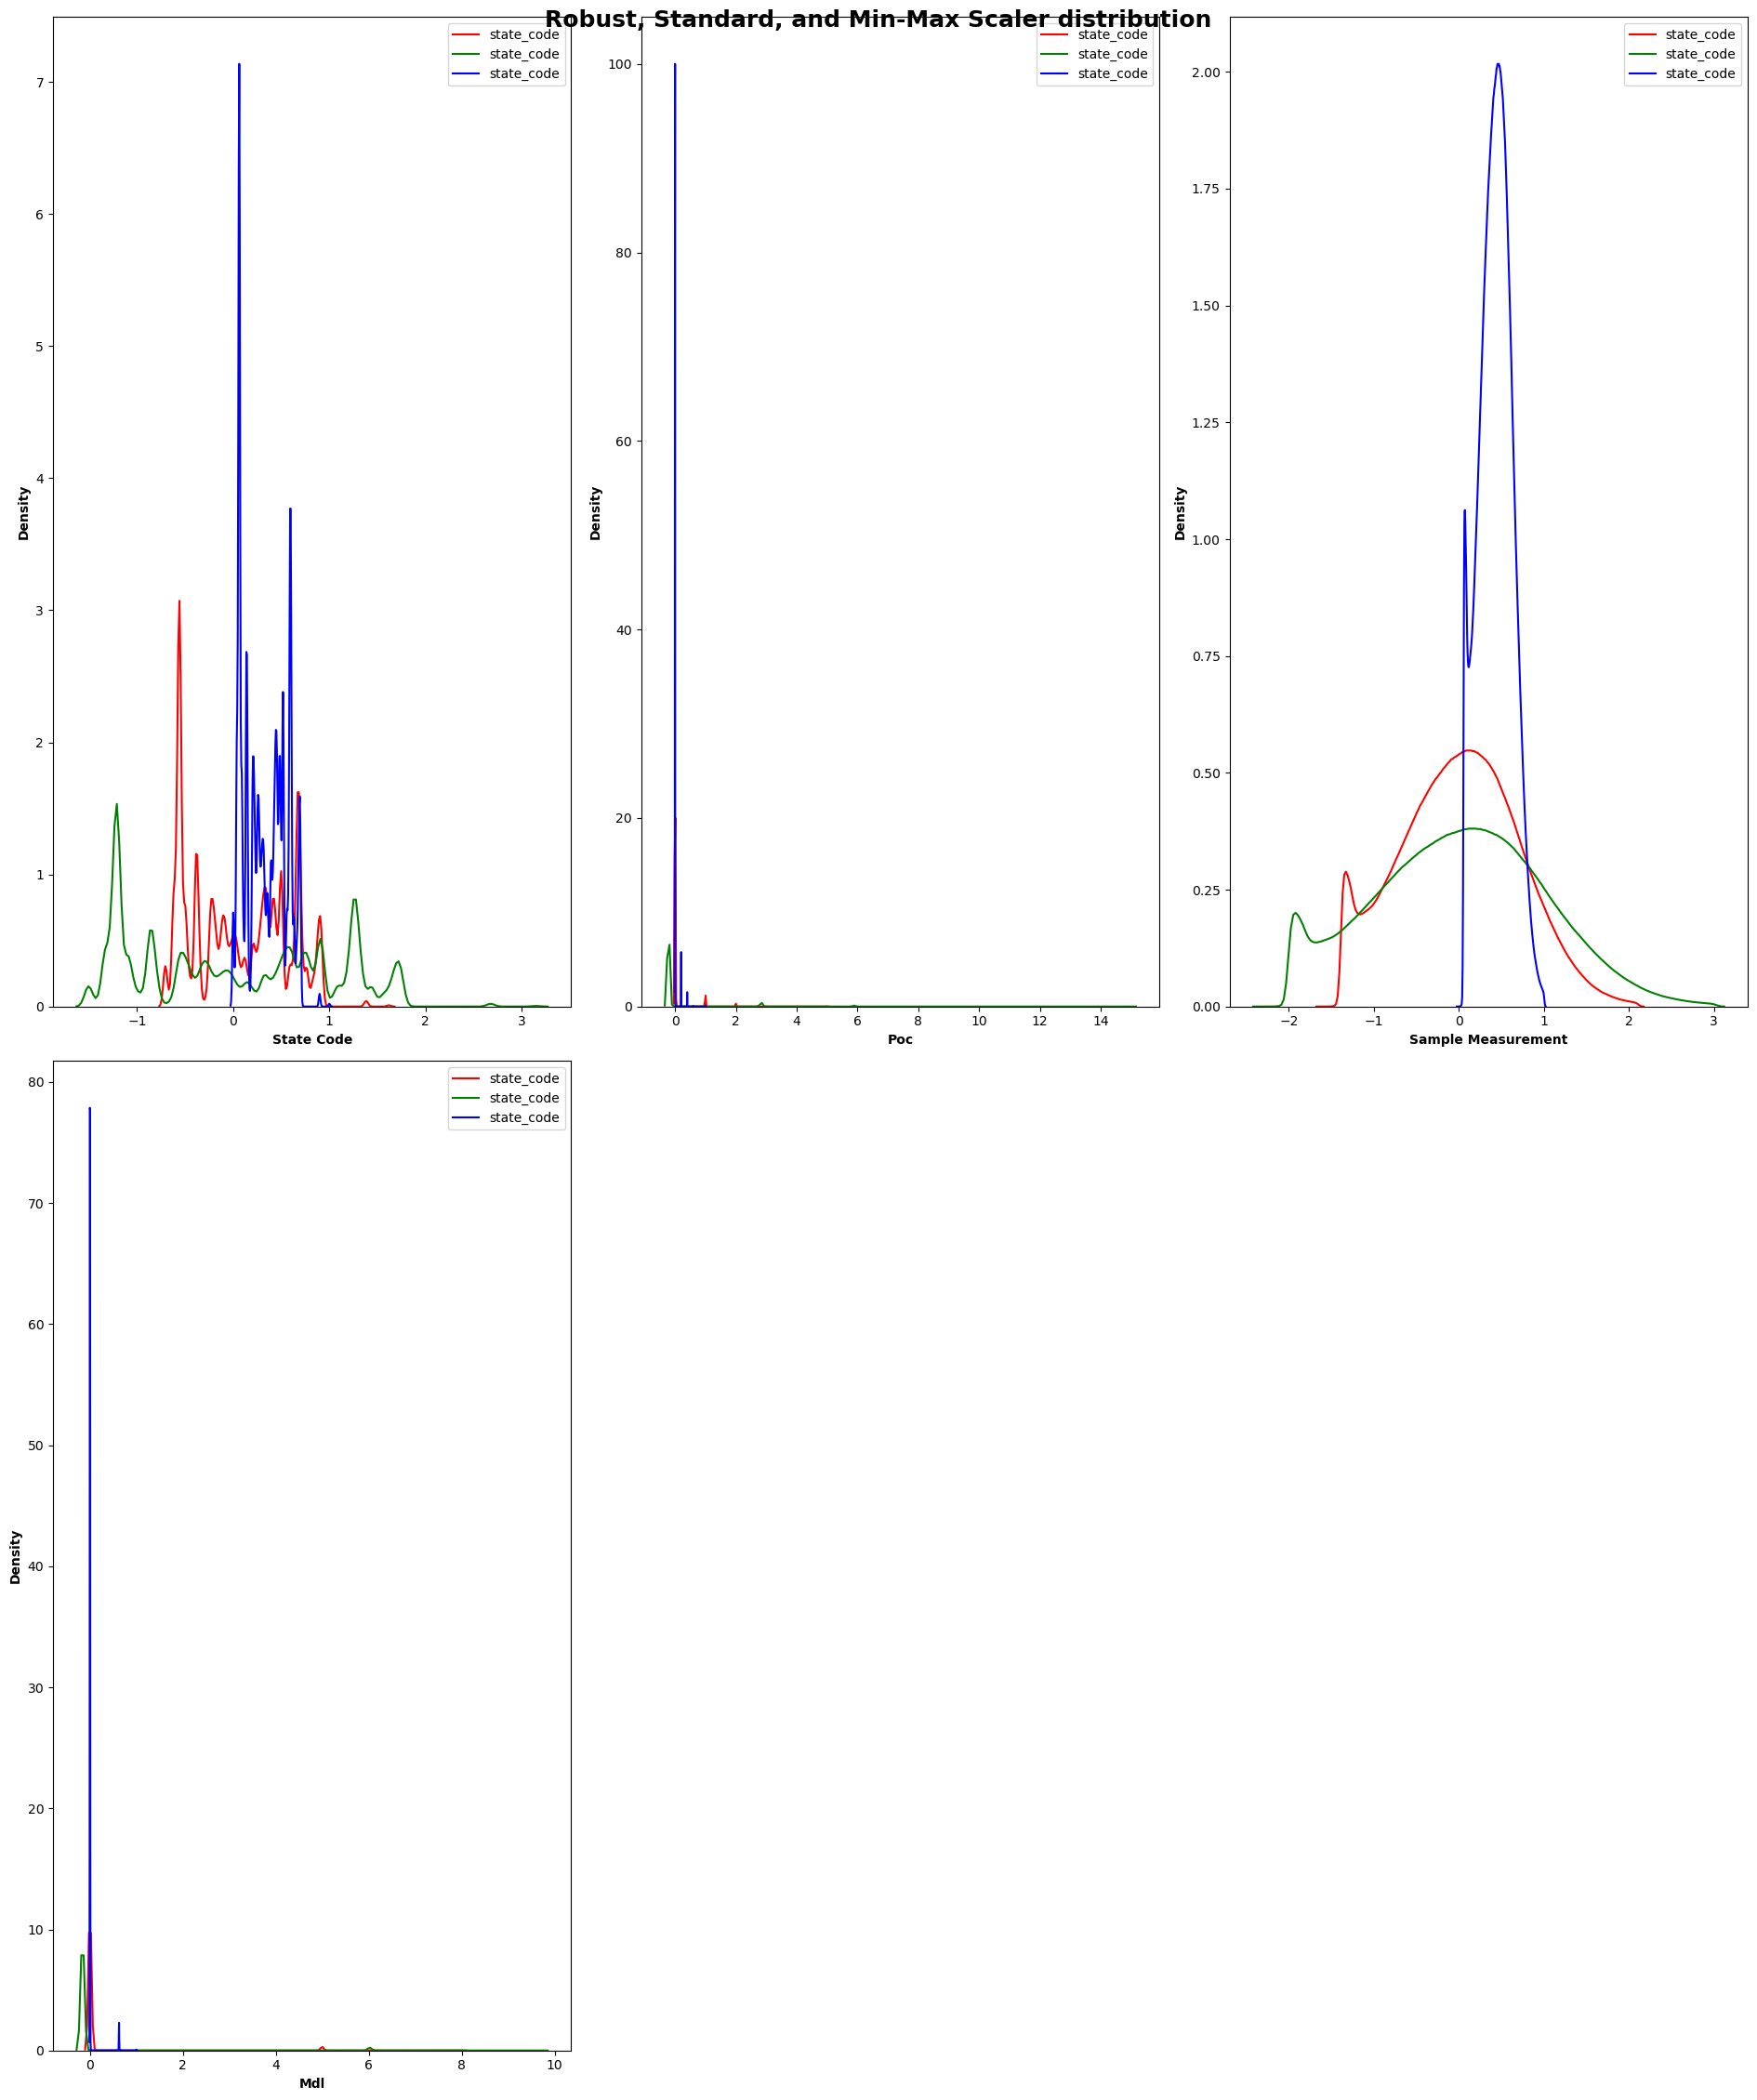

In [91]:
super_title = "Robust, Standard, and Min-Max Scaler distribution"
plot_compare_kde([df_robust, df_standard, df_minmax], columns=num_df.columns, super_title=super_title)

• Save all the transformed data so that it can be used in ML-Models for better generalization.

In [99]:
df_list = [df_robust, df_standard, df_minmax]
path_common = "../../dataset/transformed/"
parquet_ext = ".parquet"
df_path = [path_common+"df_robust"+parquet_ext, path_common+"df_standard"+parquet_ext, path_common+"df_minmax"+parquet_ext]

for i, df in enumerate(df_list):
    cu.save_df(df, "parquet", df_path[i])
    
